# Tissue samples morphing

## Preparation

### Used imports

## Sample similarity measure

The next thing to consider during preparation for Image Morphing is the 'simmilarity' score that will measure the performance of our algorithm. The overall score will be comprised of diffrent indicators: MSE (Mean-Square-Error), Histogram Entropy (Jensen-Shannon Distance), Histogram Correlation (Pearson Correlation Coefficient) ...

### Histogram analisys

### HSV Channel split

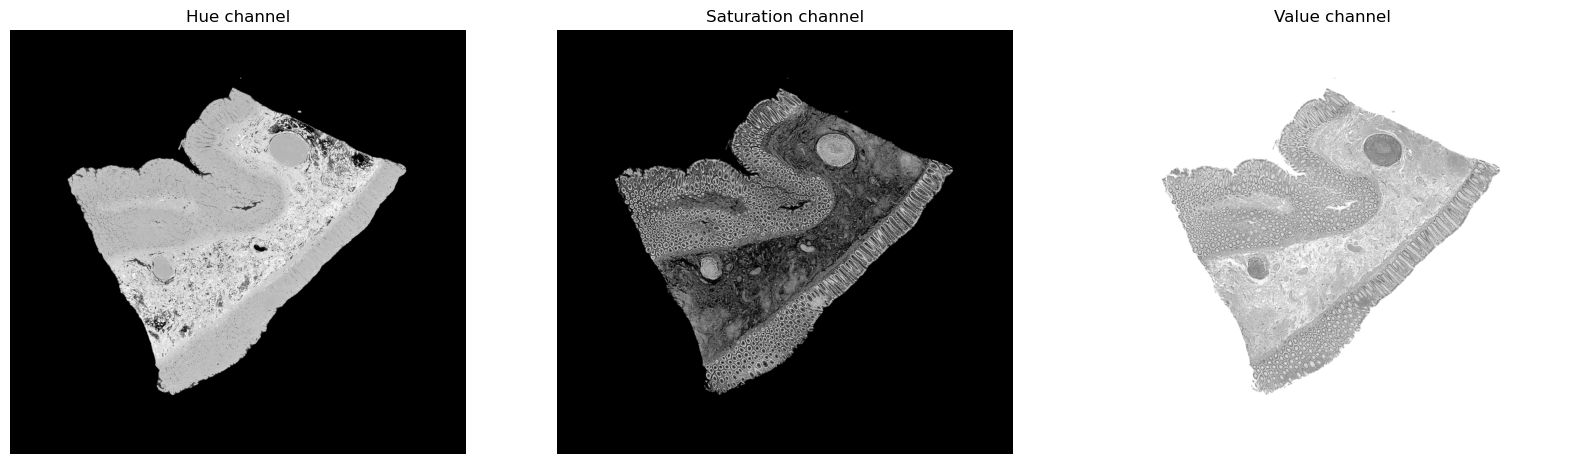

In [14]:
# Example image of one sample
image = np.array(obj_images[0])
image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV    )
# Split HSV channels
planes = cv2.split(image)

fig, axes = plt.subplots(1, 3, figsize=(20, 20))
axes[0].imshow(planes[0], cmap='gray')
axes[0].set_title('Hue channel')
axes[1].imshow(planes[1], cmap='gray')
axes[1].set_title('Saturation channel')
axes[2].imshow(planes[2], cmap='gray')
axes[2].set_title('Value channel')

for ax in axes:
    ax.axis('off')

plt.show()

### Ruifrok and Johnston deconvolution

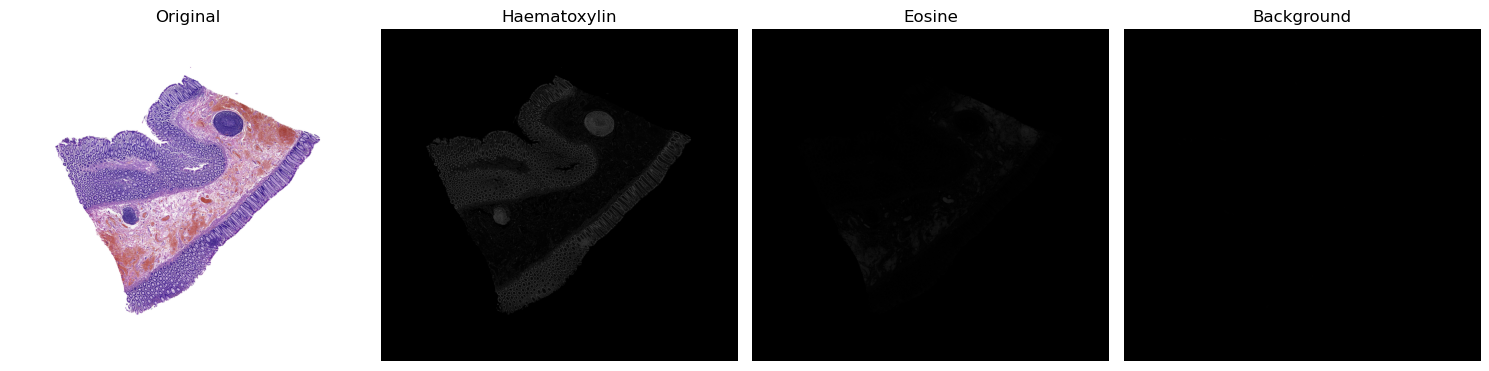

In [15]:
# Example image of one sample 
image = obj_images[0]

# Stain matrix for haematoxylin and eosin
stain_matrix = hdx_from_rgb
deconvoluted = separate_stains(image, stain_matrix)
# Scale intensity to equalize histograms

hematoxylin = deconvoluted[:, :, 0]
eosin = deconvoluted[:, :, 1]
background = deconvoluted[:, :, 2]

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(image)
axes[0].set_title("Original")
axes[1].imshow(hematoxylin, cmap='gray')
axes[1].set_title("Haematoxylin")
axes[2].imshow(eosin, cmap='gray')
axes[2].set_title("Eosine")
axes[3].imshow(background, cmap='gray')
axes[3].set_title("Background")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

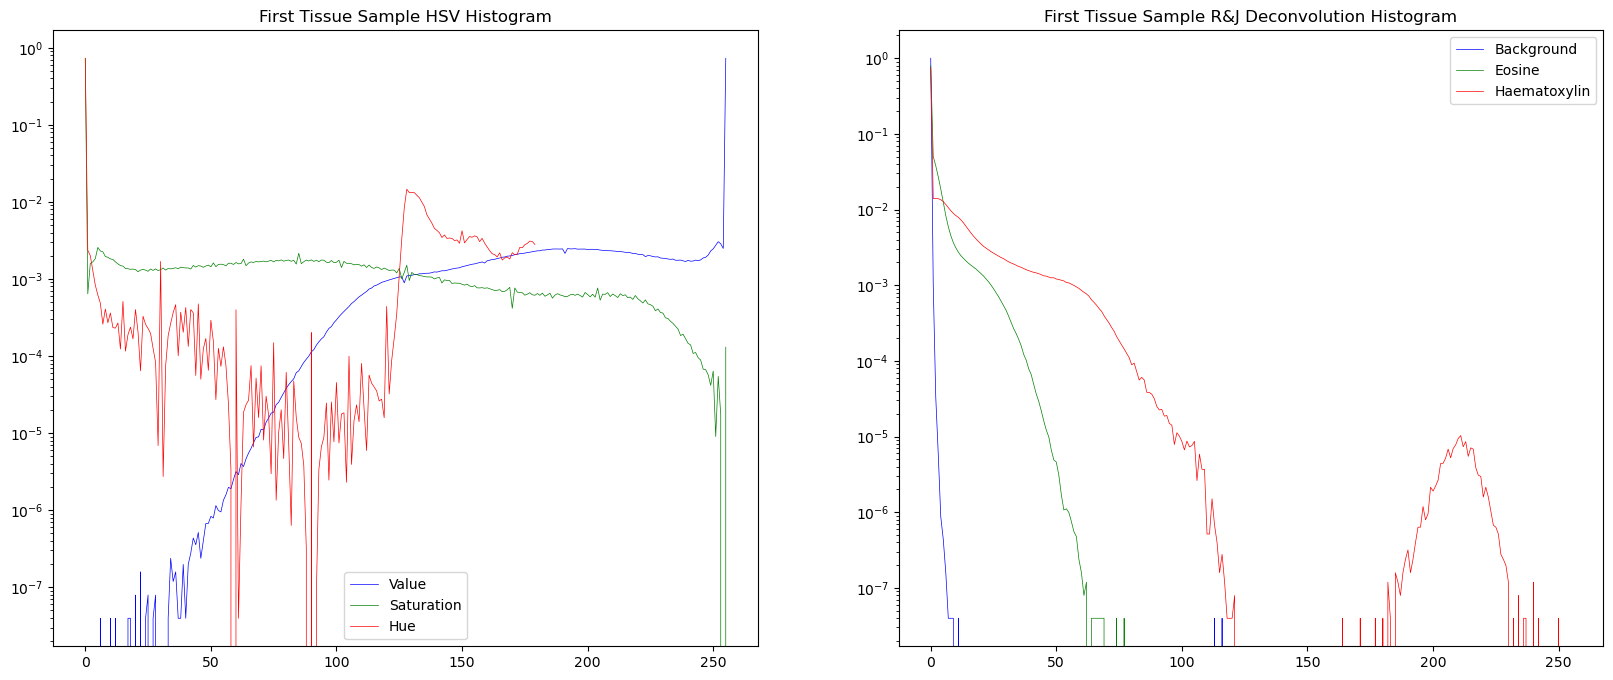

In [16]:
# Create histogram for each hsv channel
h_hist, _ = np.histogram(planes[0], bins=180, range=[0,180])
s_hist, _ = np.histogram(planes[1], bins=256, range=[0,256])
v_hist, _ = np.histogram(planes[2], bins=256, range=[0,256])

hsv_hists = [h_hist, s_hist, v_hist]

# Create histogram for each deconvoluted channel
he_hist, _ = np.histogram(hematoxylin, bins=256, range=(0,1))
e_hist, _ = np.histogram(eosin, bins=256, range=(0,1))
bg_hist, _ = np.histogram(background, bins=256, range=(0,1))

heebg_hists = [he_hist, e_hist, bg_hist]

# Normalize each histogram
def normalize_hist(hists: list):
    for i in range(len(hists)):
        hists[i] = hists[i] / np.sum(hists[i])

    return hists

hsv_hists = normalize_hist(hsv_hists)
heebg_hists = normalize_hist(heebg_hists)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].set_title('First Tissue Sample HSV Histogram')
axes[0].plot(hsv_hists[2], color='blue', linewidth=0.5, label='Value')
axes[0].plot(hsv_hists[1], color='green', linewidth=0.5, label='Saturation')
axes[0].plot(hsv_hists[0], color='red', linewidth=0.5, label='Hue')
axes[0].set_yscale('log')
axes[0].legend()

axes[1].set_title('First Tissue Sample R&J Deconvolution Histogram')
axes[1].plot(heebg_hists[2], color='blue', linewidth=0.5, label='Background')
axes[1].plot(heebg_hists[1], color='green', linewidth=0.5, label = 'Eosine')
axes[1].plot(heebg_hists[0], color='red', linewidth=0.5, label = 'Haematoxylin')
axes[1].set_yscale('log')
axes[1].legend()

plt.show()

### Histogram extraction functions

In [17]:
# Function returns histograms for channels in same order as given
def extract_histogram(image: np.ndarray, normalize: bool = False, channel_maxes=[256,256,256]):
    assert(image.shape[-1] >= len(channel_maxes))
    planes = cv2.split(image)

    hists = []
    for i, channel in enumerate(planes):
        hist, _ = np.histogram(channel, bins=channel_maxes[i], range=[0,channel_maxes[i]])
        hists.append(hist)

    if normalize:
        for i in range(len(hists)):
            hists[i] = hists[i] / np.sum(hists[i])

    return tuple(hists)

# Function returns HSV histograms with RGB Image given 
def extract_hsv_histogram(image: Image.Image, normalize: bool = False):
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    return extract_histogram(image, normalize, [180, 256, 256])

# Function returns R&J deconvoluted histograms with RGB Image given 
def extract_deconvoluted_histogram(image: Image.Image, normalize: bool = False):
    image = np.array(image)
    stain_matrix = hdx_from_rgb
    deconvoluted = separate_stains(image, stain_matrix)
    return extract_histogram(deconvoluted, normalize, [180, 256, 256])

### Histogram entropy indicator (Jensen-Shannon Distance)

In [18]:
# Examples for 
hsv_histograms_1 = extract_hsv_histogram(obj_images[0], normalize=True)
hsv_histograms_2 = extract_hsv_histogram(obj_images[1], normalize=True)

deconv_histograms_1 = extract_deconvoluted_histogram(obj_images[0], normalize=True)
deconv_histograms_2 = extract_deconvoluted_histogram(obj_images[1], normalize=True)

hsv_channels = ['Hue', 'Saturation', 'Value']
deconv_channels = ['Haematoxylin', 'Eosine', 'Background']

print('Jensen-Shannon Distance for HSV:')
for i in range(3):
    js_distance = jensenshannon(hsv_histograms_1[i], hsv_histograms_2[i])
    print(f'Channel "{hsv_channels[i]}": {js_distance}')
print()
print('Jensen-Shannon Distance for R&J Deconvolution:')
for i in range(3):
    js_distance = jensenshannon(deconv_histograms_1[i], deconv_histograms_2[i])
    print(f'Channel "{deconv_channels[i]}": {js_distance}')

Jensen-Shannon Distance for HSV:
Channel "Hue": 0.018407828642941628
Channel "Saturation": 0.02356002420076886
Channel "Value": 0.034076557907924

Jensen-Shannon Distance for R&J Deconvolution:
Channel "Haematoxylin": 0.0
Channel "Eosine": 0.00020288741035708881
Channel "Background": 0.0


### Histogram pearson correlation coefficient

In [19]:
print('Pearson correlation coefficient for HSV:')
for i in range(3):
    corr = np.corrcoef(hsv_histograms_1[i].flatten(), hsv_histograms_2[i].flatten())[0,1]
    print(f'Channel "{hsv_channels[i]}": {corr}')
print()
print('Pearson correlation coefficient for R&J Deconvolution:')
for i in range(3):
    corr = np.corrcoef(deconv_histograms_1[i].flatten(), deconv_histograms_2[i].flatten())[0,1]
    print(f'Channel "{deconv_channels[i]}": {corr}')

Pearson correlation coefficient for HSV:
Channel "Hue": 0.9999855499408635
Channel "Saturation": 0.9999965513175934
Channel "Value": 0.9999901382723266

Pearson correlation coefficient for R&J Deconvolution:
Channel "Haematoxylin": 1.0
Channel "Eosine": 0.999999999999993
Channel "Background": 1.0


### Similarity metric function

In [20]:
def similarity(sample1: np.ndarray,  sample2: np.ndarray):
    return 0